<h1 align=center><font size = 5>Segmenting and Clustering Localities in Bangalore</font></h1>

<h1 align=right><font size = 2> - By Mohammed Faisal Khan</font></h1>

## Introduction

In this project, I will be deciding which is the best possible location to open a restaurant in Bangalore with the help of a popular machine learning algorithm, the K – means clustering algorithm.  I am going to analyze the localities in Bangalore city to identify the most profitable area since the success of the restaurant depends on the people, ambience and the most important factor i.e. the density of other restaurants in that locality. 


<a href="https://www.linkedin.com/in/faisalkhan-mys/"><img src = "https://i.ytimg.com/vi/gH4BqhyTS7A/maxresdefault.jpg" width = 800> </a>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a>Scrapping data from Wikipedia Page into DataFrame.</a>

2.  <a>Getting the geographical coordinates.</a>

3.  <a>Creating map of Bangalore.</a>

4.  <a>Using the Foursquare API to explore the Localities.</a>

5.  <a>One hot encoding of Venue Categories.</a> 

6.  <a>Getting total number of venues classified as restaurants for each Locality.</a>

7.  <a>Clustering of restaurants by Localities.</a>

8.  <a>Visualization of Clusters.</a>

9.  <a>Cluster Information.</a>
    
    </font>
    </div>


## Importing Libraries

In [137]:
import numpy as np 
import pandas as pd 
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import json  # library to handle JSON files


0# installing geocoder and converting addresses into latitude and longitude values
!pip install geocoder
import geocoder
!pip install geopy
from geopy.geocoders import Nominatim

# library to handle requests
import requests 

# library to parse HTML and XML documents
!pip install beautifulsoup4
from bs4 import BeautifulSoup 

# tranforming JSON file into a pandas dataframe
from pandas.io.json import json_normalize

#visualization
import matplotlib.cm as cm
import matplotlib.colors as colors

# importing k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
!pip install folium
import folium 


print('Libraries Installed Succesfully')

Libraries Installed Succesfully


## 1. Scrapping data from Wikipedia Page into DataFrame

In [138]:
# Getting information on Areas in Bangalore
data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Bangalore").text

# parsing data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [139]:
# creating a list to store neighborhood data
neighborhoodList = []

# appending the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)

In [140]:
# creating a new DataFrame from the list
df = pd.DataFrame({"Neighborhood": neighborhoodList})
df.head(5)

,Neighborhood
0,List of areas in Bangalore Cantonment
1,List of areas in Bengaluru Pete
2,List of neighbourhoods in Bangalore
3,Adugodi
4,"Agara, Bangalore"


In [141]:
# dropping the first three rows since they don't contain neighborhood data
df.drop(df.index[0:3], inplace=True)
df.reset_index(inplace=True)
df.drop(["index"],axis=1,inplace=True)
df.head(5)

,Neighborhood
0,Adugodi
1,"Agara, Bangalore"
2,Ananthnagar
3,Anjanapura
4,Arekere


## 2. Getting the geographical coordinates

In [142]:
# defining a function to get the coordinates of bengaluru
def get_ll(neighborhood):
    llc = None
    while(llc is None):
        str_neigh = neighborhood + ', Bengaluru, Karnataka'
        g = geocoder.arcgis(str_neigh)
        llc = g.latlng
    return llc

In [143]:
# calling the function to get coordinates and storing in a new list
coords_l = []

for neighborhood in df["Neighborhood"].tolist():
    coords = get_ll(neighborhood)
    coords_l.append(coords) 


In [144]:
coords_l[0:5]   # list containing coordinates

[[12.944020000000023, 77.60800000000006],
 [12.842830000000049, 77.48759000000007],
 [12.954080000000033, 77.54135000000008],
 [12.858110000000067, 77.55909000000008],
 [12.885680000000036, 77.59668000000005]]

In [145]:
# creating temporary dataframe to populate coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords_l, columns=['Latitude', 'Longitude'])

In [146]:
df_coords.head(5)

,Latitude,Longitude
0,12.94402,77.60800
1,12.84283,77.48759
2,12.95408,77.54135
3,12.85811,77.55909
4,12.88568,77.59668


In [147]:
# merging the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [148]:
df.head(5)

,Neighborhood,Latitude,Longitude
0,Adugodi,12.94402,77.60800
1,"Agara, Bangalore",12.84283,77.48759
2,Ananthnagar,12.95408,77.54135
3,Anjanapura,12.85811,77.55909
4,Arekere,12.88568,77.59668


In [149]:
# saving the DataFrame as CSV file
df.to_csv("bl_df.csv", index=False)

## 3. Creating map of bengaluru

In [150]:
# getting the coordinates of Bengaluru
address = 'Bengaluru, Karnataka'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

12.9791198 77.5912997


In [151]:
# creating a map of Bangalore using latitude and longitude values
map_bl = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'],df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_bl)  
    
map_bl

## 4. Using Foursquare API to explore Localities

In [152]:
# defining Foursquare Credentials and Version including ID, Secret & API
CLIENT_ID = 'SI2W5BH5AS2KJW0BOPO2BVUBKOVLIQ4PXSO04KLAPPQZXTXJ' # Foursquare ID
CLIENT_SECRET = 'U4YHJ414RDIDBSYHJHCQREABBLGANU3WAF22DARVEKARBMVM' # Foursquare Secret
ACCESS_TOKEN = '2LOTMDUV2C5Y3XZMBMEGAYNAWN5F50WKB1EEA0WTWCZHOU30' # FourSquare Access Token
VERSION = '20200604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SI2W5BH5AS2KJW0BOPO2BVUBKOVLIQ4PXSO04KLAPPQZXTXJ
CLIENT_SECRET:U4YHJ414RDIDBSYHJHCQREABBLGANU3WAF22DARVEKARBMVM


### Getting top 100 venues in a 2 km radius of each neighborhood

In [153]:
# calling Foursquare API
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(df['Latitude'],df['Longitude'],df['Neighborhood']):
    
    # creating the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # making the GET request
    results_mined = requests.get(url).json()
    
    results = results_mined['response']['groups'][0]['items']
    
    # returning only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [154]:
# converting the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# defining column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

venues_df.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Adugodi,12.94402,77.608,PVR IMAX,12.934595,77.611321,Movie Theater
1,Adugodi,12.94402,77.608,Truffles Ice & Spice,12.933443,77.614265,Burger Joint
2,Adugodi,12.94402,77.608,Zingron - Naga Kitchen,12.936271,77.615051,Indian Restaurant
3,Adugodi,12.94402,77.608,Corner House,12.936164,77.615210,Dessert Shop
4,Adugodi,12.94402,77.608,PVR Cinemas,12.934389,77.611184,Multiplex


In [155]:
venues_df['VenueName'].count()  # total venues returned from foursquare API

7008

## 5. One hot encoding of Venue Categories

In [180]:
# one hot encoding
onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# moving neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head(5)

,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Shop,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Candy Store,Capitol Building,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Resort,Rest Area,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tech Startup,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store
0,Adugodi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adugodi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [181]:
# grouping venues of each category by neighborhood
grouped = onehot.groupby(["Neighborhoods"]).sum()
grouped.head(5)

,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Shop,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Candy Store,Capitol Building,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Resort,Rest Area,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tech Startup,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store
Neighborhoods,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Adugodi,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,13,0,0,0,0,0,6,0,0,0,2,1,0,0,0,0,0,0,1,0,0,4,0,0,1,0,0,2,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,14,1,0,0,0,2,0,0,2,0,2,0,0,0,0,0,1,4,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,4,0,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,1,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,

## 6. Getting total number of venues classified as restaurants for each Locality

In [182]:
# setting a string keyword to go through the venue titles and appending to DataFrame
str1 = 'Restaurant'
col_list = []

for column_id in grouped.columns:
    if str1 in column_id:
        col_list.append(column_id)
        
# adding up count of restaurants in all neighborhoods 
t_r_f = 0
ven_val = venues_df.VenueCategory

for v_c in range(len(ven_val)):
    if str1 in ven_val[v_c]:
        t_r_f = t_r_f + 1

In [183]:
# printing types of restaurants after validation
grouped['Total Restaurants'] = grouped[col_list].sum(axis=1)

t_r_cc = np.asanyarray(grouped['Total Restaurants'])

print("Total number of eateries categorized as restaurants:", t_r_f, "\n")  
if t_r_f == t_r_cc.sum():
    print("Restaurant division classification has been verified","\n") 
print("Types of Restaurants:", col_list)



Total number of eateries categorized as restaurants: 2710 

Restaurant division classification has been verified 

Types of Restaurants: ['Afghan Restaurant', 'American Restaurant', 'Andhra Restaurant', 'Asian Restaurant', 'Australian Restaurant', 'Bengali Restaurant', 'Caribbean Restaurant', 'Chettinad Restaurant', 'Chinese Restaurant', 'Comfort Food Restaurant', 'Dim Sum Restaurant', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'French Restaurant', 'German Restaurant', 'Halal Restaurant', 'Hyderabadi Restaurant', 'Indian Chinese Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Karnataka Restaurant', 'Kerala Restaurant', 'Korean Restaurant', 'Maharashtrian Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Mughlai Restaurant', 'Multicuisine Indian Restaurant', 'New American Restaurant', 'North Indian Restaurant', 'Pakistani Restaurant', 'Persian Restaurant', 

In [188]:
grouped['Latitude'] = venues_df['Latitude']
grouped['Longitude'] = venues_df['Longitude']

In [189]:
# resetting indexes
grouped = grouped.reset_index()
grouped.head(5)

,index,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bengali Restaurant,Big Box Store,Bike Shop,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Candy Store,Capitol Building,Caribbean Restaurant,Chaat Place,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Kids Store,Korean Restaurant,Lake,Light Rail Station,Lighthouse,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Resort,Rest Area,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Tech Startup,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Tibetan Restaurant,Toll Booth,Tourist Information Center,Toy / Game Store,Track Stadium,Trail,Train Station,Travel & Transport,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Women's Store,Total Restaurants,Latitude,Longitude
0,0,Adugodi,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,13,0,0,0,0,0,6,0,0,0,2,1,0,0,0,0,0,0,1,0,0,4,0,0,1,0,0,2,0,0,2,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,14,1,0,0,0,2,0,0,2,0,2,0,0,0,0,0,1,4,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,4,0,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,1,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,12.94402,77.608
1,1,Ananthnagar,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0

In [190]:
# extracting and grouping all venues classified as restaurants for each neighborhood
bl_r_1 = grouped[["Neighborhoods","Total Restaurants","Latitude","Longitude"]]
bl_r_1.head(5)

,Neighborhoods,Total Restaurants,Latitude,Longitude
0,Adugodi,42,12.94402,77.608
1,Ananthnagar,10,12.94402,77.608
2,Anjanapura,1,12.94402,77.608
3,Arekere,24,12.94402,77.608
4,Austin Town,30,12.94402,77.608


In [191]:
bl_r_1[bl_r_1['Total Restaurants'] == bl_r_1['Total Restaurants'].max()] # Neighborhoods with max restaurants

,Neighborhoods,Total Restaurants,Latitude,Longitude
63,"Jayanagar, Bangalore",55,12.94402,77.608


In [192]:
bl_r_1['Total Restaurants'].sum() # total count of restaurantsa

2710

In [193]:
bl_r_1['Neighborhoods'].count() # localities we obtained

139

## 7. Clustering of restaurants by Localities

In [194]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [195]:
# preprocessing for scaling
clustering = bl_r_1.drop(["Neighborhoods"], 1)

# feature scaling
X = clustering
X = np.nan_to_num(X)
Clus_dataSet = MinMaxScaler().fit_transform(X)
Clus_dataSet[0:5]

array([[0.76363636, 0.89517558, 1.        ],
       [0.18181818, 0.89517558, 1.        ],
       [0.01818182, 0.89517558, 1.        ],
       [0.43636364, 0.89517558, 1.        ],
       [0.54545455, 0.89517558, 1.        ]])

In [196]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

Text(0, 0.5, 'Inertia')

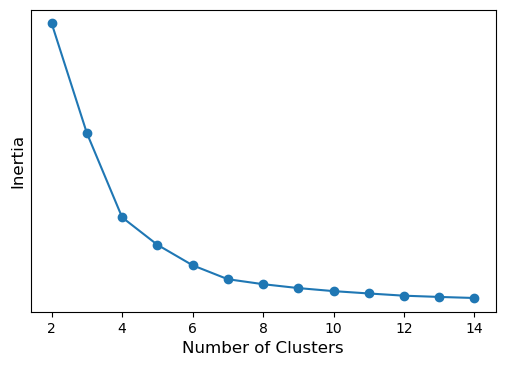

In [197]:
# finding the elbow region for optimal cluster size
krng = np.arange(2, 15)
sse = []

for k in krng:
    km = KMeans(init = "k-means++", n_clusters = k, n_init = 200, max_iter = 400)
    km.fit(Clus_dataSet)
    sse.append(km.inertia_)
    
plt.figure(1, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')

plt.scatter(krng, sse)
plt.plot(krng, sse)

frame_plt = plt.gca()

frame_plt.axes.get_yaxis().set_ticks([])

plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Inertia', fontsize=12)

In [198]:
# setting number of clusters
kclusters = 6

# running k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 200, max_iter = 400).fit(Clus_dataSet)

In [199]:
kmeans.labels_

array([2, 3, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2,
       3, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 3,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2,
       3, 3, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 2, 2, 2, 3, 3, 2,
       2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2, 2, 1, 4, 1, 4, 1, 1, 1, 1, 1, 4,
       4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 1, 4, 4, 5, 5, 5, 5, 5,
       5, 0, 0, 0, 0, 0, 0])

In [200]:
# creating a new dataframe that includes cluster labels
merged = bl_r_1.copy()
merged["Labels"] = kmeans.labels_

# displaying cluster centers
kmeans.cluster_centers_

array([[ 2.69696970e-01,  2.87277274e-01,  8.30157539e-01],
       [ 1.16666667e-01,  1.00000000e+00,  1.11022302e-16],
       [ 5.92045455e-01,  8.95175576e-01,  1.00000000e+00],
       [ 1.44405594e-01,  8.95175576e-01,  1.00000000e+00],
       [ 6.10909091e-01,  1.00000000e+00, -1.11022302e-16],
       [ 1.93939394e-01,  0.00000000e+00,  2.66166542e-01]])

In [201]:
# renaming columns for merging
merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
merged.head(5)

,Neighborhood,Total Restaurants,Latitude,Longitude,Labels
0,Adugodi,42,12.94402,77.608,2
1,Ananthnagar,10,12.94402,77.608,3
2,Anjanapura,1,12.94402,77.608,3
3,Arekere,24,12.94402,77.608,2
4,Austin Town,30,12.94402,77.608,2


In [202]:
# sorting results by Cluster Labels
merged.sort_values(["Labels"], inplace=True)
merged = merged[["Neighborhood","Total Restaurants",
                       "Labels", "Latitude","Longitude"]]

t_r_c = np.asanyarray(merged["Total Restaurants"])
c_c = []

for i in range(merged.shape[0]):
    if t_r_c[i] <40:
        if t_r_c[i] <20:
            c_c.append("Low")
        else:
            c_c.append("Medium")
    else:
        c_c.append("High")
        
merged["Restaurant Density"] = c_c

# setting index name
merged.index.name="Index Number"
merged.head(5)

,Neighborhood,Total Restaurants,Labels,Latitude,Longitude,Restaurant Density
Index Number,,,,,,
138,Yeswanthpur,6,0,12.88568,77.59668,Low
136,Yelachenahalli,20,0,12.88568,77.59668,Medium
135,Wilson Garden,25,0,12.88568,77.59668,Medium
134,"Whitefield, Bangalore",24,0,12.88568,77.59668,Medium
133,Vyalikaval,7,0,12.88568,77.59668,Low


In [203]:
# Counting occurrence of restaurant densities
rest_density=pd.get_dummies(merged[["Restaurant Density"]], prefix="", prefix_sep="").sum()
rest_dens_c = rest_density.to_frame()

In [204]:
# Renaming columns for display purposes
rest_dens_c.reset_index(inplace=True)
rest_dens_c

,index,0
0,High,13
1,Low,70
2,Medium,56


In [205]:
# Tabulating for visualization
col_n_u = ['Restaurant Density','Count']
rest_dens_c.columns = col_n_u
rest_dens_c["Level"] = [2,0,1]
rest_dens_c = rest_dens_c.sort_values("Level").drop("Level",axis=1)
rest_dens_c

,Restaurant Density,Count
1,Low,70
2,Medium,56
0,High,13


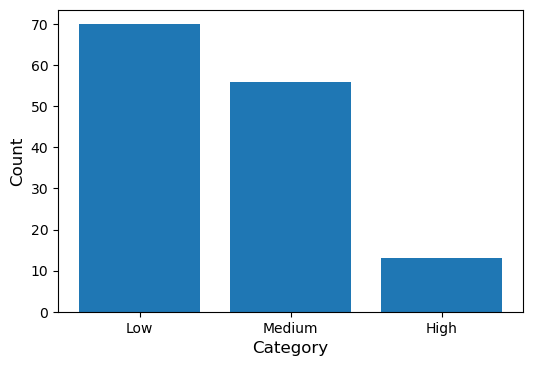

In [206]:
# Visualization of restaurant density categories
plt.figure(1, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.bar(rest_dens_c["Restaurant Density"], rest_dens_c["Count"])

plt.ylabel("Count", fontsize=12)
plt.xlabel("Category", fontsize=12)

plt.show()

## 8. Visualization of Clusters

In [207]:
# creating map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)

# setting color scheme for clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**3 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="black",
        weight=1,
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=2).add_to(map_clusters)
       
map_clusters

## 9. Cluster Information

####  Cluster 0

In [208]:
bl_r_clus_1 = merged[merged.Labels==0]
bl_r_clus_1.sort_values(["Total Restaurants"], inplace=True)
        
bl_r_clus_1

<ipython-input-208-89ee1cd4ba4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl_r_clus_1.sort_values(["Total Restaurants"], inplace=True)


,Neighborhood,Total Restaurants,Labels,Latitude,Longitude,Restaurant Density
Index Number,,,,,,
138,Yeswanthpur,6,0,12.88568,77.59668,Low
133,Vyalikaval,7,0,12.88568,77.59668,Low
137,Yelahanka,7,0,12.88568,77.59668,Low
136,Yelachenahalli,20,0,12.88568,77.59668,Medium
134,"Whitefield, Bangalore",24,0,12.88568,77.59668,Medium
135,Wilson Garden,25,0,12.88568,77.59668,Medium


#### Cluster 1

In [209]:
bl_r_clus_2 = merged[merged.Labels==1]
bl_r_clus_2.sort_values(["Total Restaurants"], inplace=True)

bl_r_clus_2

<ipython-input-209-420ebf9e38d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl_r_clus_2.sort_values(["Total Restaurants"], inplace=True)


,Neighborhood,Total Restaurants,Labels,Latitude,Longitude,Restaurant Density
Index Number,,,,,,
106,Ramagondanahalli,1,1,12.95408,77.54135,Low
121,Sulikunte,1,1,12.95408,77.54135,Low
124,Thindlu,1,1,12.95408,77.54135,Low
117,Singasandra,2,1,12.95408,77.54135,Low
107,Ramamurthy Nagar,3,1,12.95408,77.54135,Low
104,"Rajarajeshwari Nagar, Bangalore",4,1,12.95408,77.54135,Low
108,Ramanjaneyanagar,6,1,12.95408,77.54135,Low
105,Ramachandrapura,7,1,12.95408,77.54135,Low
100,Peenya,8,1,12.95408,77.54135,Low


####  Cluster 2

In [210]:
bl_r_clus_3 = merged[merged.Labels==2]
bl_r_clus_3.sort_values(["Total Restaurants"], inplace=True)

bl_r_clus_3

<ipython-input-210-87cba9946322>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl_r_clus_3.sort_values(["Total Restaurants"], inplace=True)


,Neighborhood,Total Restaurants,Labels,Latitude,Longitude,Restaurant Density
Index Number,,,,,,
98,Padmanabhanagar,21,2,12.94402,77.608,Medium
96,Nandini Layout,21,2,12.94402,77.608,Medium
14,Basaveshwaranagar,21,2,12.94402,77.608,Medium
90,Mathikere,21,2,12.94402,77.608,Medium
36,Dollars Colony,23,2,12.94402,77.608,Medium
3,Arekere,24,2,12.94402,77.608,Medium
68,Kaggadasapura,24,2,12.94402,77.608,Medium
9,Baiyyappanahalli,25,2,12.94402,77.608,Medium
10,Baiyyappanahalli Manavarthe Kaval,25,2,12.94402,77.608,Medium


#### Cluster 3

In [211]:
bl_r_clus_4 = merged[merged.Labels==3]
bl_r_clus_4.sort_values(["Total Restaurants"], inplace=True)

bl_r_clus_4

<ipython-input-211-d87c5d624b96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl_r_clus_4.sort_values(["Total Restaurants"], inplace=True)


,Neighborhood,Total Restaurants,Labels,Latitude,Longitude,Restaurant Density
Index Number,,,,,,
55,Horamavu,0,3,12.94402,77.608,Low
7,"Bagalur, Bangalore Urban",0,3,12.94402,77.608,Low
52,Hebbagodi,1,3,12.94402,77.608,Low
66,Jigani,1,3,12.94402,77.608,Low
2,Anjanapura,1,3,12.94402,77.608,Low
44,Gangamma Circle,1,3,12.94402,77.608,Low
22,Bommasandra,1,3,12.94402,77.608,Low
17,Bharathnagar,1,3,12.94402,77.608,Low
26,Carmelaram,1,3,12.94402,77.608,Low


#### Cluster 4

In [212]:
bl_r_clus_5 = merged[merged.Labels==4]
bl_r_clus_5.sort_values(["Total Restaurants"], inplace=True)

bl_r_clus_5

<ipython-input-212-6cb234c6d0e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl_r_clus_5.sort_values(["Total Restaurants"], inplace=True)


,Neighborhood,Total Restaurants,Labels,Latitude,Longitude,Restaurant Density
Index Number,,,,,,
116,"Siddapura, Bangalore",22,4,12.95408,77.54135,Medium
122,Tannery Road,22,4,12.95408,77.54135,Medium
112,Sanjaynagar,23,4,12.95408,77.54135,Medium
110,Sadashivanagar,27,4,12.95408,77.54135,Medium
103,Rajajinagar,31,4,12.95408,77.54135,Medium
120,Suddaguntepalya,32,4,12.95408,77.54135,Medium
119,"Statue of Queen Victoria, Bangalore",34,4,12.95408,77.54135,Medium
109,Richmond Town,34,4,12.95408,77.54135,Medium
113,Seshadripuram,35,4,12.95408,77.54135,Medium


#### Cluster 5

In [213]:
bl_r_clus_6 = merged[merged.Labels==5]
bl_r_clus_6.sort_values(["Total Restaurants"], inplace=True)

bl_r_clus_6

<ipython-input-213-b994a1118cd1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl_r_clus_6.sort_values(["Total Restaurants"], inplace=True)


,Neighborhood,Total Restaurants,Labels,Latitude,Longitude,Restaurant Density
Index Number,,,,,,
130,Vidyaranyapura,1,5,12.85811,77.55909,Low
131,"Vijayanagar, Bangalore",1,5,12.85811,77.55909,Low
127,Uttarahalli,2,5,12.85811,77.55909,Low
128,Varthur,13,5,12.85811,77.55909,Low
132,Vimanapura,15,5,12.85811,77.55909,Low
129,Vasanth Nagar,32,5,12.85811,77.55909,Medium


<h1 align=right><font size = 2> - By Mohammed Faisal Khan</font></h1>